# Data Transformation - Crime Data Analysis

**Project:** Crime Data from 2020 to Present

**Objective:** Transform and manipulate the dataset to create new features and improve its structure for advanced analysis.

---

## Table of Contents
1. [Import Libraries & Load Cleaned Data](#1)
2. [New Feature Creation](#2)
3. [Filtering and Selecting Data](#3)
4. [Merging and Concatenation](#4)
5. [Pivoting and Reshaping](#5)
6. [Automated Transformation Pipeline](#6)
7. [Summary & Export Transformed Data](#7)

## 1. Import Libraries & Load Cleaned Data <a id='1'></a>

First, let's import necessary libraries and load our cleaned dataset.

In [1]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set style for visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


In [2]:
# Load the cleaned dataset from the data cleaning step
# If you have exported it as 'Crime_Data_Cleaned.csv', use that
# Otherwise, we'll load and apply basic cleaning
try:
    df = pd.read_csv('Crime_Data_Cleaned.csv')
    print(f"✓ Cleaned dataset loaded successfully!")
except FileNotFoundError:
    print("⚠ Crime_Data_Cleaned.csv not found. Loading original and applying basic cleaning...")
    df = pd.read_csv('Crime_Data_from_2020_to_Present_50k.csv')
    
    # Quick basic cleaning if cleaned file doesn't exist
    df['Date Rptd'] = pd.to_datetime(df['Date Rptd'], errors='coerce')
    df['DATE OCC'] = pd.to_datetime(df['DATE OCC'], errors='coerce')
    df = df.dropna(subset=['DR_NO', 'Date Rptd', 'DATE OCC'])
    df['Vict Age'] = df['Vict Age'].fillna(0)
    print(f"✓ Dataset loaded and cleaned!")

print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"\nFirst look at the data:")
df.head()

✓ Cleaned dataset loaded successfully!
Shape: 50,000 rows × 24 columns

First look at the data:


,dr_number,date_reported,date_occurred,time_occurred,area_code,area_name,reporting_district,crime_part,crime_code,crime_description,modus_operandi_codes,victim_age,victim_sex,victim_descent,premise_code,premise_description,weapon_code,weapon_description,status_code,status_description,crime_code_1,location,latitude,longitude
0,200216570,2020-10-23,2020-10-01,2000,2,Rampart,249,2,956,"LETTERS, LEWD - TELEPHONE CALLS, LEWD",1906 1820 0913,42,Unknown,Unknown,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,Unknown,AA,Adult Arrest,956.0,600 ST PAUL AV,34.0542,-118.2611
1,211009787,2021-07-04,2021-07-03,2250,10,West Valley,1011,2,354,THEFT OF IDENTITY,1822 0377,49,Unknown,Unknown,101.0,STREET,NaN,Unknown,AA,Adult Arrest,354.0,ARMINTA,34.2047,-118.5531
2,201225286,2020-11-26,2020-11-26,1610,12,77th Street,1241,1,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",1822 2021 0340 0334 0353 0445,35,Unknown,Unknown,108.0,PARKING LOT,102.0,HAND GUN,IC,Invest Cont,230.0,6400 WEST BL,33.9810,-118.3352
3,231614576,2023-12-01,2023-10-04,900,16,Foothill,1657,1,440,THEFT PLAIN - PETTY ($950 & UNDER),0344,50,Unknown,Unknown,116.0,OTHER/OUTSIDE,NaN,Unknown,IC,Invest Cont,440.0,10100 HILLHAVEN AV,34.2523,-118.2898
4,221007431,2022-04-01,2022-03-31,1830,10,West Valley,1004,1,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),1822 0344,40,Unknown,Unknown,701.0,HOSPITAL,NaN,Unknown,IC,Invest Cont,420.0,18300 ROSCOE BL,34.2208,-118.5317


## 2. New Feature Creation <a id='2'></a>

Create meaningful new features using `apply()`, `map()`, and `transform()` methods.

### 2.1 DateTime Features

Extract temporal features from date columns.

In [4]:
print("=" * 80)
print("CREATING DATETIME FEATURES")
print("=" * 80)

# Check which column names exist in the dataset
if 'date_reported' in df.columns:
    # Columns are already renamed (from cleaned data)
    date_rptd_col = 'date_reported'
    date_occ_col = 'date_occurred'
    time_occ_col = 'time_occurred'
    print("✓ Using renamed columns from cleaned data")
else:
    # Using original column names
    date_rptd_col = 'Date Rptd'
    date_occ_col = 'DATE OCC'
    time_occ_col = 'TIME OCC'
    print("✓ Using original column names")

# Convert date columns to datetime
df[date_rptd_col] = pd.to_datetime(df[date_rptd_col], errors='coerce')
df[date_occ_col] = pd.to_datetime(df[date_occ_col], errors='coerce')

# Extract temporal features from date occurred
df['year'] = df[date_occ_col].dt.year
df['month'] = df[date_occ_col].dt.month
df['month_name'] = df[date_occ_col].dt.month_name()
df['day'] = df[date_occ_col].dt.day
df['day_of_week'] = df[date_occ_col].dt.dayofweek
df['day_name'] = df[date_occ_col].dt.day_name()
df['quarter'] = df[date_occ_col].dt.quarter
df['week_of_year'] = df[date_occ_col].dt.isocalendar().week

# Create time-based categories using apply()
def get_time_period(hour):
    """Categorize time into periods"""
    if pd.isna(hour):
        return 'Unknown'
    elif 0 <= hour < 6:
        return 'Late Night (00:00-05:59)'
    elif 6 <= hour < 12:
        return 'Morning (06:00-11:59)'
    elif 12 <= hour < 18:
        return 'Afternoon (12:00-17:59)'
    else:
        return 'Evening (18:00-23:59)'

# Extract hour from TIME OCC (format: 2330 means 23:30)
df['hour'] = (df[time_occ_col] // 100).astype(int)
df['minute'] = (df[time_occ_col] % 100).astype(int)
df['time_period'] = df['hour'].apply(get_time_period)

# Calculate reporting delay (days between occurrence and report)
df['reporting_delay_days'] = (df[date_rptd_col] - df[date_occ_col]).dt.days

# Weekend indicator
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

print("✓ Created temporal features:")
print(f"   - Year, Month, Day, Quarter, Week")
print(f"   - Day of Week, Weekend Indicator")
print(f"   - Hour, Time Period")
print(f"   - Reporting Delay")

print("\nSample of new features:")
# Use the date column that exists
display_date_col = date_occ_col
df[[display_date_col, 'year', 'month_name', 'day_name', 'hour', 'time_period', 
    'is_weekend', 'reporting_delay_days']].head(10)

CREATING DATETIME FEATURES
✓ Using renamed columns from cleaned data
✓ Created temporal features:
   - Year, Month, Day, Quarter, Week
   - Day of Week, Weekend Indicator
   - Hour, Time Period
   - Reporting Delay

Sample of new features:


,date_occurred,year,month_name,day_name,hour,time_period,is_weekend,reporting_delay_days
0,2020-10-01,2020,October,Thursday,20,Evening (18:00-23:59),0,22
1,2021-07-03,2021,July,Saturday,22,Evening (18:00-23:59),1,1
2,2020-11-26,2020,November,Thursday,16,Afternoon (12:00-17:59),0,0
3,2023-10-04,2023,October,Wednesday,9,Morning (06:00-11:59),0,58
4,2022-03-31,2022,March,Thursday,18,Evening (18:00-23:59),0,1
5,2024-02-29,2024,February,Thursday,21,Evening (18:00-23:59),0,0
6,2021-09-21,2021,September,Tuesday,13,Afternoon (12:00-17:59),0,0
7,2021-08-18,2021,August,Wednesday,14,Afternoon (12:00-17:59),0,0
8,2023-08-08,2023,August,Tuesday,14,Afternoon (12:00-17:59),0,6
9,2024-11-29,2024,November,Friday,16,Afternoon (12:00-17:59),0,4


### 2.2 Crime Severity & Category Features

Create features to categorize crime severity and types.

In [5]:
print("\n" + "=" * 80)
print("CREATING CRIME CATEGORY FEATURES")
print("=" * 80)

# Detect column names
part_col = 'crime_part' if 'crime_part' in df.columns else 'Part 1-2'
crime_desc_col = 'crime_description' if 'crime_description' in df.columns else 'Crm Cd Desc'
weapon_desc_col = 'weapon_description' if 'weapon_description' in df.columns else 'Weapon Desc'

# Crime severity based on Part 1-2 classification
df['crime_severity'] = df[part_col].map({
    1: 'Part 1 - Serious Crime',
    2: 'Part 2 - Less Serious Crime'
})

# Categorize crimes by type using map()
def categorize_crime(description):
    """Categorize crimes into broad categories"""
    if pd.isna(description):
        return 'Unknown'
    
    description = str(description).upper()
    
    # Violent crimes
    if any(word in description for word in ['ASSAULT', 'BATTERY', 'HOMICIDE', 'MURDER', 
                                              'RAPE', 'KIDNAPPING', 'THREATENING']):
        return 'Violent Crime'
    # Property crimes
    elif any(word in description for word in ['THEFT', 'BURGLARY', 'ROBBERY', 'STOLEN', 
                                                'SHOPLIFTING', 'EMBEZZLEMENT']):
        return 'Property Crime'
    # Vehicle-related
    elif any(word in description for word in ['VEHICLE', 'AUTO', 'CAR', 'MOTORCYCLE']):
        return 'Vehicle-Related'
    # Fraud/Financial
    elif any(word in description for word in ['FRAUD', 'IDENTITY', 'FORGERY', 'CREDIT CARD',
                                                'COUNTERFEIT']):
        return 'Fraud/Financial'
    # Vandalism
    elif 'VANDALISM' in description:
        return 'Vandalism'
    # Drug-related
    elif any(word in description for word in ['DRUG', 'NARCOTIC', 'MARIJUANA']):
        return 'Drug-Related'
    # Weapons
    elif any(word in description for word in ['WEAPON', 'FIREARM', 'GUN']):
        return 'Weapons'
    else:
        return 'Other'

df['crime_category'] = df[crime_desc_col].apply(categorize_crime)

# Weapon involvement flag
df['weapon_involved'] = df[weapon_desc_col].apply(lambda x: 0 if pd.isna(x) or x == '' else 1)

# Create weapon category using map()
def categorize_weapon(weapon_desc):
    """Categorize weapon types"""
    if pd.isna(weapon_desc) or weapon_desc == '':
        return 'No Weapon'
    
    weapon_str = str(weapon_desc).upper()
    
    if any(word in weapon_str for word in ['GUN', 'FIREARM', 'PISTOL', 'REVOLVER', 'RIFLE']):
        return 'Firearm'
    elif any(word in weapon_str for word in ['KNIFE', 'BLADE', 'SWORD', 'MACHETE']):
        return 'Blade/Knife'
    elif 'STRONG-ARM' in weapon_str or 'HANDS' in weapon_str or 'FIST' in weapon_str:
        return 'Physical Force'
    elif any(word in weapon_str for word in ['VERBAL', 'THREAT']):
        return 'Verbal Threat'
    elif 'VEHICLE' in weapon_str:
        return 'Vehicle'
    else:
        return 'Other Weapon'

df['weapon_category'] = df[weapon_desc_col].apply(categorize_weapon)

print("✓ Created crime category features:")
print(f"   - Crime Severity (Part 1/2)")
print(f"   - Crime Category (Violent, Property, etc.)")
print(f"   - Weapon Involvement Flag")
print(f"   - Weapon Category")

print("\nCrime Category Distribution:")
print(df['crime_category'].value_counts())

print("\nWeapon Category Distribution:")
print(df['weapon_category'].value_counts())


CREATING CRIME CATEGORY FEATURES
✓ Created crime category features:
   - Crime Severity (Part 1/2)
   - Crime Category (Violent, Property, etc.)
   - Weapon Involvement Flag
   - Weapon Category

Crime Category Distribution:
crime_category
Property Crime     28870
Violent Crime      10458
Vandalism           4379
Other               4367
Weapons             1819
Vehicle-Related       98
Fraud/Financial        9
Name: count, dtype: int64

Weapon Category Distribution:
weapon_category
Other Weapon      36935
Physical Force     8706
Firearm            1980
Verbal Threat      1201
Blade/Knife        1011
Vehicle             167
Name: count, dtype: int64


### 2.3 Victim Demographics & Location Features

Transform victim and location information.

In [6]:
print("\n" + "=" * 80)
print("CREATING VICTIM & LOCATION FEATURES")
print("=" * 80)

# Detect column names
vict_age_col = 'victim_age' if 'victim_age' in df.columns else 'Vict Age'
premise_desc_col = 'premise_description' if 'premise_description' in df.columns else 'Premis Desc'
dr_no_col = 'dr_number' if 'dr_number' in df.columns else 'DR_NO'
area_name_col = 'area_name' if 'area_name' in df.columns else 'AREA NAME'

# Age group categorization using transform() and apply()
def categorize_age(age):
    """Categorize victim age into groups"""
    if pd.isna(age) or age == 0:
        return 'Unknown'
    elif age < 13:
        return 'Child (0-12)'
    elif 13 <= age < 18:
        return 'Teen (13-17)'
    elif 18 <= age < 25:
        return 'Young Adult (18-24)'
    elif 25 <= age < 35:
        return 'Adult (25-34)'
    elif 35 <= age < 50:
        return 'Middle Age (35-49)'
    elif 50 <= age < 65:
        return 'Senior (50-64)'
    elif age >= 65:
        return 'Elderly (65+)'
    else:
        return 'Unknown'

df['victim_age_group'] = df[vict_age_col].apply(categorize_age)

# Location type categorization
def categorize_location(premise_desc):
    """Categorize premise into location types"""
    if pd.isna(premise_desc):
        return 'Unknown'
    
    premise_str = str(premise_desc).upper()
    
    if any(word in premise_str for word in ['STREET', 'SIDEWALK', 'ALLEY', 'HIGHWAY']):
        return 'Public Street'
    elif any(word in premise_str for word in ['DWELLING', 'RESIDENCE', 'HOUSE', 'APARTMENT']):
        return 'Residential'
    elif any(word in premise_str for word in ['STORE', 'SHOP', 'MARKET', 'MALL', 'RESTAURANT']):
        return 'Commercial'
    elif any(word in premise_str for word in ['PARKING', 'GARAGE', 'LOT']):
        return 'Parking Area'
    elif any(word in premise_str for word in ['SCHOOL', 'UNIVERSITY', 'COLLEGE']):
        return 'Educational'
    elif any(word in premise_str for word in ['BANK', 'ATM']):
        return 'Financial'
    elif any(word in premise_str for word in ['PARK', 'PLAYGROUND', 'BEACH']):
        return 'Recreation'
    elif any(word in premise_str for word in ['CHURCH', 'TEMPLE', 'MOSQUE']):
        return 'Religious'
    elif 'VEHICLE' in premise_str:
        return 'Vehicle'
    else:
        return 'Other'

df['location_type'] = df[premise_desc_col].apply(categorize_location)

# Create area risk score based on crime frequency using transform()
area_crime_counts = df.groupby(area_name_col)[dr_no_col].transform('count')
df['area_crime_frequency'] = area_crime_counts

# Normalize to create risk score (0-100)
max_freq = df['area_crime_frequency'].max()
df['area_risk_score'] = (df['area_crime_frequency'] / max_freq * 100).round(2)

print("✓ Created victim & location features:")
print(f"   - Victim Age Group")
print(f"   - Location Type")
print(f"   - Area Crime Frequency")
print(f"   - Area Risk Score (0-100)")

print("\nVictim Age Group Distribution:")
print(df['victim_age_group'].value_counts())

print("\nLocation Type Distribution:")
print(df['location_type'].value_counts())

print("\nTop 5 High-Risk Areas:")
print(df.groupby(area_name_col)['area_risk_score'].first().sort_values(ascending=False).head())


CREATING VICTIM & LOCATION FEATURES
✓ Created victim & location features:
   - Victim Age Group
   - Location Type
   - Area Crime Frequency
   - Area Risk Score (0-100)

Victim Age Group Distribution:
victim_age_group
Unknown                13383
Middle Age (35-49)     11065
Adult (25-34)          10034
Senior (50-64)          6633
Young Adult (18-24)     4894
Elderly (65+)           2671
Teen (13-17)             897
Child (0-12)             423
Name: count, dtype: int64

Location Type Distribution:
location_type
Public Street    15283
Residential      14971
Other             8658
Parking Area      4844
Commercial        3350
Vehicle           1476
Educational        516
Recreation         474
Financial          309
Religious          119
Name: count, dtype: int64

Top 5 High-Risk Areas:
area_name
Central        100.00
77th Street     88.56
Southwest       86.86
Pacific         86.62
Hollywood       75.01
Name: area_risk_score, dtype: float64


## 3. Filtering and Selecting Data <a id='3'></a>

Demonstrate advanced filtering techniques using boolean indexing, `loc[]`, and `iloc[]`.

### 3.1 Boolean Indexing Examples

In [8]:
print("=" * 80)
print("FILTERING DATA - BOOLEAN INDEXING")
print("=" * 80)

# Detect column names
date_occ_col = 'date_occurred' if 'date_occurred' in df.columns else 'DATE OCC'
crime_desc_col = 'crime_description' if 'crime_description' in df.columns else 'Crm Cd Desc'
area_name_col = 'area_name' if 'area_name' in df.columns else 'AREA NAME'

# Example 1: Filter violent crimes in 2024
violent_crimes_2024 = df[(df['crime_category'] == 'Violent Crime') & (df['year'] == 2024)]
print(f"\n1. Violent Crimes in 2024: {len(violent_crimes_2024):,} records")
print(violent_crimes_2024[[date_occ_col, crime_desc_col, area_name_col, 'victim_age_group']].head())

# Example 2: Filter crimes with weapons on weekends
weekend_weapon_crimes = df[(df['weapon_involved'] == 1) & (df['is_weekend'] == 1)]
print(f"\n2. Weekend Crimes with Weapons: {len(weekend_weapon_crimes):,} records")
print(weekend_weapon_crimes[['day_name', crime_desc_col, 'weapon_category', area_name_col]].head())

# Example 3: Filter high-risk areas (risk score > 50) with property crimes
high_risk_property = df[(df['area_risk_score'] > 50) & (df['crime_category'] == 'Property Crime')]
print(f"\n3. Property Crimes in High-Risk Areas: {len(high_risk_property):,} records")
print(high_risk_property[[area_name_col, 'area_risk_score', crime_desc_col, 'location_type']].head())

# Example 4: Complex filter - Evening crimes targeting elderly victims
elderly_evening = df[
    (df['time_period'] == 'Evening (18:00-23:59)') & 
    (df['victim_age_group'] == 'Elderly (65+)') &
    (df['crime_severity'] == 'Part 1 - Serious Crime')
]
print(f"\n4. Evening Serious Crimes Against Elderly: {len(elderly_evening):,} records")
print(elderly_evening[[date_occ_col, 'time_period', 'victim_age_group', crime_desc_col]].head())

# Example 5: Multi-condition filter using query() method
query_result = df.query('year >= 2023 & weapon_involved == 1 & is_weekend == 0')
print(f"\n5. Weekday Crimes with Weapons (2023+): {len(query_result):,} records")
print(query_result[[date_occ_col, 'day_name', 'weapon_category', crime_desc_col]].head())

FILTERING DATA - BOOLEAN INDEXING

1. Violent Crimes in 2024: 756 records
    date_occurred                               crime_description  \
5      2024-02-29               INTIMATE PARTNER - SIMPLE ASSAULT   
66     2024-02-28                        BATTERY - SIMPLE ASSAULT   
234    2024-01-01  ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT   
264    2024-01-01                        BATTERY - SIMPLE ASSAULT   
351    2024-03-18           INTIMATE PARTNER - AGGRAVATED ASSAULT   

       area_name    victim_age_group  
5        Rampart       Adult (25-34)  
66       Central  Middle Age (35-49)  
234    Southeast  Middle Age (35-49)  
264      Olympic       Adult (25-34)  
351  77th Street       Adult (25-34)  

2. Weekend Crimes with Weapons: 14,320 records
    day_name                               crime_description weapon_category  \
1   Saturday                               THEFT OF IDENTITY    Other Weapon   
13  Saturday  ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT         

### 3.2 Using loc[] and iloc[]

In [10]:
print("\n" + "=" * 80)
print("FILTERING DATA - LOC[] AND ILOC[]")
print("=" * 80)

# Detect column names
date_occ_col = 'date_occurred' if 'date_occurred' in df.columns else 'DATE OCC'
crime_desc_col = 'crime_description' if 'crime_description' in df.columns else 'Crm Cd Desc'
area_name_col = 'area_name' if 'area_name' in df.columns else 'AREA NAME'
status_desc_col = 'status_description' if 'status_description' in df.columns else 'Status Desc'

# loc[] - Label-based indexing
print("\n1. Using loc[] - Select specific columns for violent crimes:")
violent_subset = df.loc[df['crime_category'] == 'Violent Crime', 
                        [date_occ_col, crime_desc_col, area_name_col, 'weapon_category', status_desc_col]]
print(f"Selected {len(violent_subset):,} violent crimes")
print(violent_subset.head())

# loc[] with multiple conditions
print("\n2. Using loc[] with multiple conditions - 2024 crimes in specific areas:")
specific_areas = ['Central', 'Hollywood', 'Wilshire']
subset_2024 = df.loc[(df['year'] == 2024) & (df[area_name_col].isin(specific_areas)),
                      [date_occ_col, area_name_col, crime_desc_col, 'crime_category']]
print(f"Found {len(subset_2024):,} records")
print(subset_2024.head())

# iloc[] - Position-based indexing
print("\n3. Using iloc[] - First 10 rows, specific columns:")
position_subset = df.iloc[:10, [1, 2, 3, 8, 9]]  # Select first 10 rows, columns by position
print(position_subset)

# iloc[] - Sample every 100th row
print("\n4. Using iloc[] - Every 100th record:")
sampled_data = df.iloc[::100, :]
print(f"Sampled {len(sampled_data):,} records from {len(df):,}")
print(sampled_data[[date_occ_col, crime_desc_col, area_name_col]].head())

# Combining loc[] and iloc[]
print("\n5. Complex selection - Last 1000 violent crimes, specific columns:")
violent_indices = df[df['crime_category'] == 'Violent Crime'].index
last_1000_violent = df.loc[violent_indices[-1000:], 
                            [date_occ_col, crime_desc_col, 'victim_age_group', 'weapon_category']]
print(f"Selected last 1000 from {len(violent_indices):,} violent crimes")
print(last_1000_violent.head())


FILTERING DATA - LOC[] AND ILOC[]

1. Using loc[] - Select specific columns for violent crimes:
Selected 10,458 violent crimes
   date_occurred                               crime_description    area_name  \
2     2020-11-26  ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT  77th Street   
5     2024-02-29               INTIMATE PARTNER - SIMPLE ASSAULT      Rampart   
7     2021-08-18               INTIMATE PARTNER - SIMPLE ASSAULT      Rampart   
13    2023-01-14  ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT      Rampart   
22    2023-02-19         CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT    Southeast   

   weapon_category status_description  
2          Firearm        Invest Cont  
5   Physical Force        Invest Cont  
7   Physical Force        Invest Cont  
13         Firearm        Invest Cont  
22  Physical Force        Invest Cont  

2. Using loc[] with multiple conditions - 2024 crimes in specific areas:
Found 1,123 records
    date_occurred  area_name                       

## 4. Merging and Concatenation <a id='4'></a>

Merge with supplementary datasets and demonstrate concatenation techniques.

### 4.1 Create Supplementary Datasets

Create additional datasets to demonstrate merging techniques.

In [12]:
print("=" * 80)
print("CREATING SUPPLEMENTARY DATASETS FOR MERGING")
print("=" * 80)

# Create Area Demographics Dataset (simulated)
area_demographics = pd.DataFrame({
    'AREA NAME': ['Central', 'Rampart', 'Southwest', 'Hollenbeck', 'Harbor',
                  'Hollywood', 'Wilshire', 'West LA', 'Van Nuys', 'West Valley',
                  'Northeast', '77th Street', 'Newton', 'Pacific', 'N Hollywood',
                  'Foothill', 'Devonshire', 'Southeast', 'Mission', 'Olympic',
                  'Topanga'],
    'population': [54000, 61000, 58000, 52000, 46000,
                   78000, 72000, 65000, 68000, 70000,
                   55000, 51000, 49000, 47000, 64000,
                   60000, 62000, 53000, 59000, 66000, 48000],
    'median_income': [45000, 38000, 42000, 35000, 52000,
                      68000, 85000, 95000, 55000, 62000,
                      48000, 32000, 30000, 75000, 50000,
                      58000, 72000, 36000, 44000, 52000, 88000],
    'area_size_sq_miles': [5.2, 6.8, 7.1, 6.3, 8.5,
                           7.9, 6.4, 5.8, 9.2, 10.1,
                           6.7, 8.3, 5.9, 7.5, 8.8,
                           9.5, 11.2, 7.7, 8.9, 6.2, 12.5]
})

print("\n✓ Area Demographics Dataset Created:")
print(area_demographics.head(10))

# Detect column names for merging operations
area_name_col = 'area_name' if 'area_name' in df.columns else 'AREA NAME'
status_desc_col = 'status_description' if 'status_description' in df.columns else 'Status Desc'
dr_no_col = 'dr_number' if 'dr_number' in df.columns else 'DR_NO'

# Create Crime Resolution Statistics (based on actual data)
resolution_stats = df.groupby(area_name_col).agg({
    status_desc_col: lambda x: (x == 'Invest Cont').sum() / len(x) * 100,
    dr_no_col: 'count'
}).reset_index()
resolution_stats.columns = ['AREA NAME', 'resolution_rate', 'total_cases']
resolution_stats['resolution_rate'] = resolution_stats['resolution_rate'].round(2)

print("\n✓ Crime Resolution Statistics Created:")
print(resolution_stats.head(10))

# Create seasonal crime patterns
seasonal_data = df.groupby([area_name_col, 'quarter']).size().reset_index(name='crime_count')
seasonal_data_pivot = seasonal_data.pivot(index=area_name_col, columns='quarter', values='crime_count').fillna(0)
seasonal_data_pivot.columns = [f'Q{int(col)}_crimes' for col in seasonal_data_pivot.columns]
seasonal_data_pivot = seasonal_data_pivot.reset_index()
seasonal_data_pivot.rename(columns={area_name_col: 'AREA NAME'}, inplace=True)

print("\n✓ Seasonal Crime Patterns Created:")
print(seasonal_data_pivot.head())

CREATING SUPPLEMENTARY DATASETS FOR MERGING

✓ Area Demographics Dataset Created:
     AREA NAME  population  median_income  area_size_sq_miles
0      Central       54000          45000                 5.2
1      Rampart       61000          38000                 6.8
2    Southwest       58000          42000                 7.1
3   Hollenbeck       52000          35000                 6.3
4       Harbor       46000          52000                 8.5
5    Hollywood       78000          68000                 7.9
6     Wilshire       72000          85000                 6.4
7      West LA       65000          95000                 5.8
8     Van Nuys       68000          55000                 9.2
9  West Valley       70000          62000                10.1

✓ Crime Resolution Statistics Created:
     AREA NAME  resolution_rate  total_cases
0  77th Street            75.25         3059
1      Central            86.65         3454
2   Devonshire            79.72         2110
3     Foothill  

### 4.2 Merge Operations

Demonstrate different merge strategies.

In [14]:
print("\n" + "=" * 80)
print("MERGING DATASETS")
print("=" * 80)

# Detect column names for display
crime_desc_col = 'crime_description' if 'crime_description' in df.columns else 'Crm Cd Desc'

# Add AREA NAME column to df if it uses area_name
if 'area_name' in df.columns and 'AREA NAME' not in df.columns:
    df['AREA NAME'] = df['area_name']

# 1. Inner Merge - Add demographics to crime data
print("\n1. INNER MERGE - Crime data with area demographics:")
df_with_demographics = df.merge(area_demographics, on='AREA NAME', how='inner')
print(f"   Original: {len(df):,} rows")
print(f"   After merge: {len(df_with_demographics):,} rows")
print(f"   New columns added: {list(area_demographics.columns[1:])}")
print("\nSample:")
print(df_with_demographics[['AREA NAME', crime_desc_col, 'population', 'median_income']].head())

# 2. Left Merge - Add resolution statistics
print("\n2. LEFT MERGE - Add resolution statistics:")
df_enriched = df_with_demographics.merge(resolution_stats, on='AREA NAME', how='left')
print(f"   After merge: {len(df_enriched):,} rows")
print(f"   New columns: resolution_rate, total_cases")
print("\nSample:")
print(df_enriched[['AREA NAME', crime_desc_col, 'resolution_rate']].head())

# 3. Merge with seasonal data
print("\n3. MERGE - Add seasonal crime patterns:")
df_complete = df_enriched.merge(seasonal_data_pivot, on='AREA NAME', how='left')
print(f"   After merge: {len(df_complete):,} rows")
print(f"   Total columns: {len(df_complete.columns)}")
print("\nNew seasonal columns:")
print([col for col in df_complete.columns if 'Q' in col and 'crimes' in col])

# Calculate crime per capita
df_complete['crimes_per_1000'] = (df_complete['total_cases'] / df_complete['population'] * 1000).round(2)

print("\n✓ Enriched dataset created with merged data")
print(f"   Final shape: {df_complete.shape}")

# Display sample of enriched data
print("\nSample of enriched data:")
print(df_complete[['AREA NAME', 'crime_category', 'population', 'median_income', 
                   'resolution_rate', 'crimes_per_1000']].head(10))


MERGING DATASETS

1. INNER MERGE - Crime data with area demographics:
   Original: 50,000 rows
   After merge: 50,000 rows
   New columns added: ['population', 'median_income', 'area_size_sq_miles']

Sample:
     AREA NAME                                crime_description  population  \
0      Rampart          LETTERS, LEWD  -  TELEPHONE CALLS, LEWD       61000   
1  West Valley                                THEFT OF IDENTITY       70000   
2  77th Street   ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT       51000   
3     Foothill               THEFT PLAIN - PETTY ($950 & UNDER)       60000   
4  West Valley  THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)       70000   

   median_income  
0          38000  
1          62000  
2          32000  
3          58000  
4          62000  

2. LEFT MERGE - Add resolution statistics:
   After merge: 50,000 rows
   New columns: resolution_rate, total_cases

Sample:
     AREA NAME                                crime_description  \
0      Ra

### 4.3 Concatenation

Combine datasets vertically and horizontally.

In [16]:
print("\n" + "=" * 80)
print("CONCATENATION OPERATIONS")
print("=" * 80)

# 1. Vertical concatenation - Split by year and recombine
print("\n1. VERTICAL CONCATENATION - Split by year and recombine:")
df_2020 = df_complete[df_complete['year'] == 2020].copy()
df_2021 = df_complete[df_complete['year'] == 2021].copy()
df_2022 = df_complete[df_complete['year'] == 2022].copy()

print(f"   2020: {len(df_2020):,} rows")
print(f"   2021: {len(df_2021):,} rows")
print(f"   2022: {len(df_2022):,} rows")

# Concatenate vertically
df_concat_vertical = pd.concat([df_2020, df_2021, df_2022], axis=0, ignore_index=True)
print(f"   Combined: {len(df_concat_vertical):,} rows")

# 2. Horizontal concatenation - Add summary statistics
print("\n2. HORIZONTAL CONCATENATION - Add crime statistics:")

# Detect column names
dr_no_col = 'dr_number' if 'dr_number' in df_complete.columns else 'DR_NO'

# Create area-level summary statistics
area_stats = df_complete.groupby('AREA NAME').agg({
    dr_no_col: 'count',
    'weapon_involved': 'sum',
    'is_weekend': 'sum'
}).reset_index()
area_stats.columns = ['AREA NAME', 'area_total_crimes', 'area_weapon_crimes', 'area_weekend_crimes']

# Sample records for horizontal concat demo
sample_df = df_complete[[dr_no_col, 'AREA NAME', crime_desc_col]].head(1000).copy()
sample_with_stats = sample_df.merge(area_stats, on='AREA NAME', how='left')

print(f"   Original columns: {len(sample_df.columns)}")
print(f"   After concat: {len(sample_with_stats.columns)}")
print("\nSample:")
print(sample_with_stats.head())

# 3. Concatenate different crime categories
print("\n3. CONCATENATION - Combine different crime categories:")
violent = df_complete[df_complete['crime_category'] == 'Violent Crime'].copy()
property_crime = df_complete[df_complete['crime_category'] == 'Property Crime'].copy()
vehicle = df_complete[df_complete['crime_category'] == 'Vehicle-Related'].copy()

violent['priority'] = 'High'
property_crime['priority'] = 'Medium'
vehicle['priority'] = 'Medium'

priority_crimes = pd.concat([violent, property_crime, vehicle], 
                            keys=['Violent', 'Property', 'Vehicle'],
                            names=['Category', 'Index'])

print(f"   Violent: {len(violent):,}")
print(f"   Property: {len(property_crime):,}")
print(f"   Vehicle: {len(vehicle):,}")
print(f"   Combined with priority: {len(priority_crimes):,}")
print("\n✓ Concatenation operations completed")


CONCATENATION OPERATIONS

1. VERTICAL CONCATENATION - Split by year and recombine:
   2020: 10,063 rows
   2021: 10,364 rows
   2022: 11,539 rows
   Combined: 31,966 rows

2. HORIZONTAL CONCATENATION - Add crime statistics:
   Original columns: 3
   After concat: 6

Sample:
   dr_number    AREA NAME                                crime_description  \
0  200216570      Rampart          LETTERS, LEWD  -  TELEPHONE CALLS, LEWD   
1  211009787  West Valley                                THEFT OF IDENTITY   
2  201225286  77th Street   ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT   
3  231614576     Foothill               THEFT PLAIN - PETTY ($950 & UNDER)   
4  221007431  West Valley  THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)   

   area_total_crimes  area_weapon_crimes  area_weekend_crimes  
0               2363                2363                  723  
1               2124                2124                  581  
2               3059                3059                  834  

## 5. Pivoting and Reshaping <a id='5'></a>

Reshape data using `pivot()`, `melt()`, `stack()`, and `unstack()`.

### 5.1 Pivot Tables

PIVOTING DATA

1. PIVOT TABLE - Crimes by Area and Time Period:
time_period  Afternoon (12:00-17:59)  Evening (18:00-23:59)  \
AREA NAME                                                     
77th Street                      912                    945   
Central                         1026                   1138   
Devonshire                       750                    631   
Foothill                         545                    478   
Harbor                           580                    643   
Hollenbeck                       596                    577   
Hollywood                        817                    809   
Mission                          668                    613   
N Hollywood                      825                    768   
Newton                           761                    687   
Northeast                        721                    692   
Olympic                          722                    819   
Pacific                         1011                  

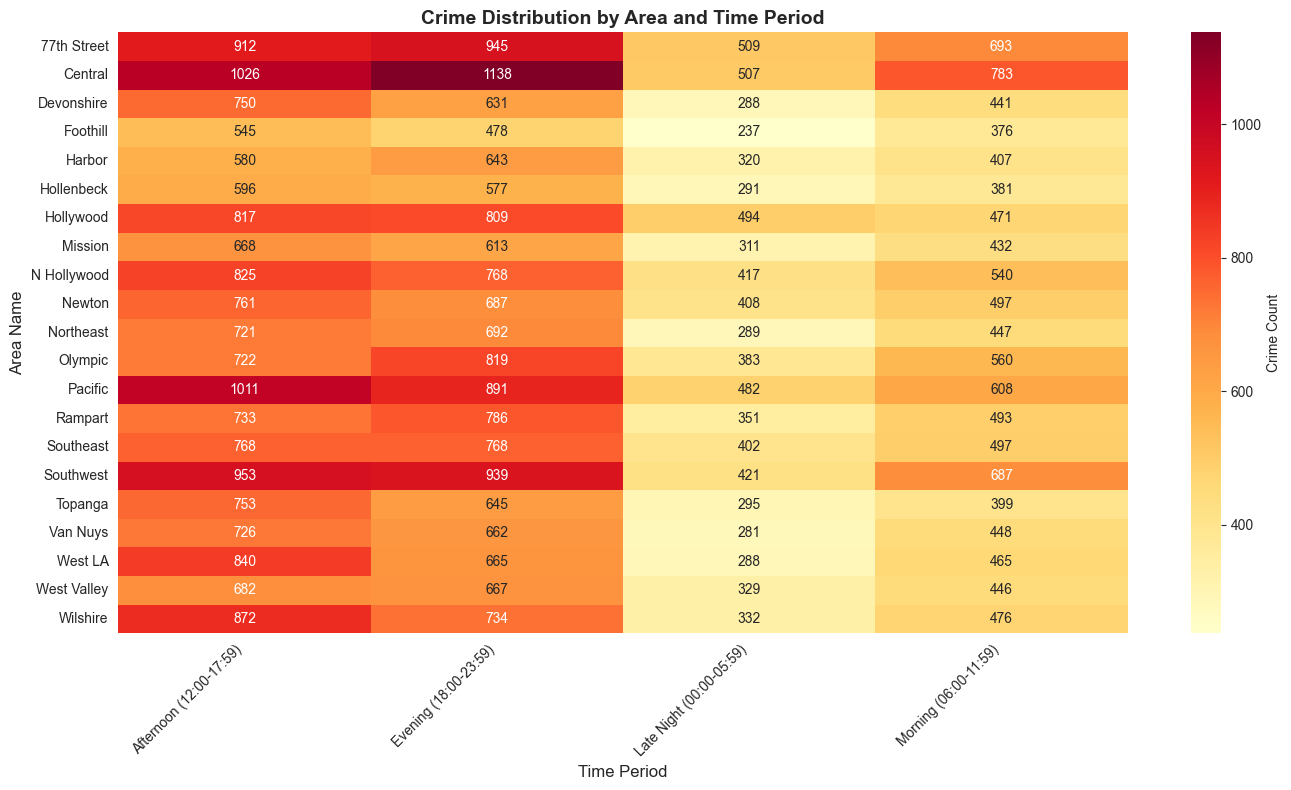


✓ Pivot tables created successfully


In [18]:
print("=" * 80)
print("PIVOTING DATA")
print("=" * 80)

# Detect column names
dr_no_col = 'dr_number' if 'dr_number' in df_complete.columns else 'DR_NO'
vict_age_col = 'victim_age' if 'victim_age' in df_complete.columns else 'Vict Age'

# 1. Pivot: Crime counts by area and time period
print("\n1. PIVOT TABLE - Crimes by Area and Time Period:")
pivot_time = df_complete.pivot_table(
    values=dr_no_col,
    index='AREA NAME',
    columns='time_period',
    aggfunc='count',
    fill_value=0
)
print(pivot_time)

# 2. Pivot: Average victim age by crime category and area
print("\n2. PIVOT TABLE - Average Victim Age by Crime Category and Area (Top 5 areas):")
top_areas = df_complete['AREA NAME'].value_counts().head(5).index
pivot_age = df_complete[df_complete['AREA NAME'].isin(top_areas)].pivot_table(
    values=vict_age_col,
    index='AREA NAME',
    columns='crime_category',
    aggfunc='mean',
    fill_value=0
).round(1)
print(pivot_age)

# 3. Pivot with multiple aggregations
print("\n3. PIVOT TABLE - Multiple Aggregations (Crime stats by year and category):")
pivot_multi = df_complete.pivot_table(
    values=dr_no_col,
    index='year',
    columns='crime_category',
    aggfunc=['count', 'size'],
    fill_value=0
)
print(pivot_multi.head())

# Visualize pivot table
print("\n4. VISUALIZATION - Crimes by Time Period and Area (Heatmap):")
plt.figure(figsize=(14, 8))
sns.heatmap(pivot_time, annot=True, fmt='g', cmap='YlOrRd', cbar_kws={'label': 'Crime Count'})
plt.title('Crime Distribution by Area and Time Period', fontsize=14, fontweight='bold')
plt.xlabel('Time Period', fontsize=12)
plt.ylabel('Area Name', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n✓ Pivot tables created successfully")

### 5.2 Melt - Wide to Long Format

In [20]:
print("\n" + "=" * 80)
print("MELT - RESHAPING FROM WIDE TO LONG")
print("=" * 80)

# Create a wide-format dataset with quarterly crime data
quarterly_wide = df_complete.groupby(['AREA NAME', 'quarter']).size().unstack(fill_value=0)
quarterly_wide.columns = [f'Q{int(col)}' for col in quarterly_wide.columns]
quarterly_wide = quarterly_wide.reset_index()

print("\n1. BEFORE MELT (Wide Format) - Quarterly crimes by area:")
print(quarterly_wide.head(10))
print(f"Shape: {quarterly_wide.shape}")

# Melt to long format
quarterly_long = quarterly_wide.melt(
    id_vars=['AREA NAME'],
    value_vars=['Q1', 'Q2', 'Q3', 'Q4'],
    var_name='Quarter',
    value_name='Crime_Count'
)

print("\n2. AFTER MELT (Long Format):")
print(quarterly_long.head(20))
print(f"Shape: {quarterly_long.shape}")

# Detect column names
dr_no_col = 'dr_number' if 'dr_number' in df_complete.columns else 'DR_NO'
vict_age_col = 'victim_age' if 'victim_age' in df_complete.columns else 'Vict Age'

# Another example: Melt weapon and victim data
crime_sample = df_complete[[dr_no_col, 'AREA NAME', 'weapon_involved', 'is_weekend', 
                             vict_age_col]].head(1000).copy()

print("\n3. BEFORE MELT - Multiple indicator columns:")
print(crime_sample.head())

crime_melted = crime_sample.melt(
    id_vars=[dr_no_col, 'AREA NAME'],
    value_vars=['weapon_involved', 'is_weekend'],
    var_name='Indicator',
    value_name='Value'
)

print("\n4. AFTER MELT - Indicators as rows:")
print(crime_melted.head(10))
print(f"Original shape: {crime_sample.shape} → Melted shape: {crime_melted.shape}")

print("\n✓ Melt operations completed")


MELT - RESHAPING FROM WIDE TO LONG

1. BEFORE MELT (Wide Format) - Quarterly crimes by area:
     AREA NAME   Q1   Q2   Q3   Q4
0  77th Street  803  759  770  727
1      Central  905  831  865  853
2   Devonshire  576  489  520  525
3     Foothill  414  438  378  406
4       Harbor  486  504  517  443
5   Hollenbeck  478  438  453  476
6    Hollywood  726  656  631  578
7      Mission  550  501  487  486
8  N Hollywood  694  636  612  608
9       Newton  638  603  596  516
Shape: (21, 5)

2. AFTER MELT (Long Format):
      AREA NAME Quarter  Crime_Count
0   77th Street      Q1          803
1       Central      Q1          905
2    Devonshire      Q1          576
3      Foothill      Q1          414
4        Harbor      Q1          486
5    Hollenbeck      Q1          478
6     Hollywood      Q1          726
7       Mission      Q1          550
8   N Hollywood      Q1          694
9        Newton      Q1          638
10    Northeast      Q1          534
11      Olympic      Q1         

### 5.3 Stack and Unstack

In [21]:
print("\n" + "=" * 80)
print("STACK AND UNSTACK OPERATIONS")
print("=" * 80)

# Create multi-index data for demonstration
crime_summary = df_complete.groupby(['AREA NAME', 'year', 'crime_category']).size().unstack(fill_value=0)

print("\n1. BEFORE STACK - Crime categories as columns:")
print(crime_summary.head())
print(f"Shape: {crime_summary.shape}")

# Stack: Convert columns to rows
stacked_data = crime_summary.stack()
print("\n2. AFTER STACK - Crime categories as index:")
print(stacked_data.head(20))
print(f"Type: {type(stacked_data)}")

# Unstack: Convert index level to columns
unstacked_data = stacked_data.unstack(level=0)  # Unstack AREA NAME
print("\n3. UNSTACK (level=0) - Areas as columns:")
print(unstacked_data.head())

# Unstack different level
unstacked_year = stacked_data.unstack(level='year')
print("\n4. UNSTACK (level='year') - Years as columns:")
print(unstacked_year.head(10))

# Complex example: Multi-level stacking/unstacking
crime_time_area = df_complete.groupby(['AREA NAME', 'time_period', 'crime_category']).size().unstack(fill_value=0)
print("\n5. MULTI-LEVEL DATA:")
print(crime_time_area.head(10))

# Stack to convert to long format
stacked_complex = crime_time_area.stack()
print("\n6. STACKED MULTI-LEVEL:")
print(stacked_complex.head(20))
print(f"Index levels: {stacked_complex.index.names}")

print("\n✓ Stack/Unstack operations completed")


STACK AND UNSTACK OPERATIONS

1. BEFORE STACK - Crime categories as columns:
crime_category    Fraud/Financial  Other  Property Crime  Vandalism  \
AREA NAME   year                                                      
77th Street 2020                0     61             285         68   
            2021                0     63             280         58   
            2022                0     48             392         43   
            2023                0     56             346         34   
            2024                0     26             199         28   

crime_category    Vehicle-Related  Violent Crime  Weapons  
AREA NAME   year                                           
77th Street 2020                0            191       49  
            2021                2            198       41  
            2022                2            204       42  
            2023                1            203       38  
            2024                2             83       16  
Shap

## 6. Automated Transformation Pipeline <a id='6'></a>

Create an automated, reusable pipeline for data transformation.

In [22]:
class CrimeDataTransformer:
    """
    Automated pipeline for transforming crime data.
    Applies all transformation steps in a reproducible manner.
    """
    
    def __init__(self, df, demographics_df=None):
        """
        Initialize the transformer with data.
        
        Parameters:
        -----------
        df : pd.DataFrame
            Raw crime data
        demographics_df : pd.DataFrame, optional
            Area demographics data for merging
        """
        self.df = df.copy()
        self.demographics_df = demographics_df
        self.transformed_df = None
        
    def create_temporal_features(self):
        """Create datetime-based features"""
        print("[1/6] Creating temporal features...")
        
        # Convert dates
        self.df['Date Rptd'] = pd.to_datetime(self.df['Date Rptd'], errors='coerce')
        self.df['DATE OCC'] = pd.to_datetime(self.df['DATE OCC'], errors='coerce')
        
        # Extract features
        self.df['year'] = self.df['DATE OCC'].dt.year
        self.df['month'] = self.df['DATE OCC'].dt.month
        self.df['month_name'] = self.df['DATE OCC'].dt.month_name()
        self.df['day_of_week'] = self.df['DATE OCC'].dt.dayofweek
        self.df['day_name'] = self.df['DATE OCC'].dt.day_name()
        self.df['quarter'] = self.df['DATE OCC'].dt.quarter
        
        # Time period
        self.df['hour'] = (self.df['TIME OCC'] // 100).astype(int)
        self.df['time_period'] = self.df['hour'].apply(self._get_time_period)
        
        # Weekend flag
        self.df['is_weekend'] = (self.df['day_of_week'] >= 5).astype(int)
        
        # Reporting delay
        self.df['reporting_delay_days'] = (self.df['Date Rptd'] - self.df['DATE OCC']).dt.days
        
        print("   ✓ Temporal features created")
        return self
    
    def create_crime_features(self):
        """Create crime categorization features"""
        print("[2/6] Creating crime features...")
        
        # Crime severity
        self.df['crime_severity'] = self.df['Part 1-2'].map({
            1: 'Part 1 - Serious Crime',
            2: 'Part 2 - Less Serious Crime'
        })
        
        # Crime category
        self.df['crime_category'] = self.df['Crm Cd Desc'].apply(self._categorize_crime)
        
        # Weapon features
        self.df['weapon_involved'] = self.df['Weapon Desc'].apply(
            lambda x: 0 if pd.isna(x) or x == '' else 1
        )
        self.df['weapon_category'] = self.df['Weapon Desc'].apply(self._categorize_weapon)
        
        print("   ✓ Crime features created")
        return self
    
    def create_demographic_features(self):
        """Create victim and location features"""
        print("[3/6] Creating demographic features...")
        
        # Age groups
        self.df['victim_age_group'] = self.df['Vict Age'].apply(self._categorize_age)
        
        # Location types
        self.df['location_type'] = self.df['Premis Desc'].apply(self._categorize_location)
        
        # Area statistics
        area_counts = self.df.groupby('AREA NAME')['DR_NO'].transform('count')
        self.df['area_crime_frequency'] = area_counts
        max_freq = self.df['area_crime_frequency'].max()
        self.df['area_risk_score'] = (self.df['area_crime_frequency'] / max_freq * 100).round(2)
        
        print("   ✓ Demographic features created")
        return self
    
    def merge_supplementary_data(self):
        """Merge with supplementary datasets"""
        print("[4/6] Merging supplementary data...")
        
        if self.demographics_df is not None:
            self.df = self.df.merge(self.demographics_df, on='AREA NAME', how='left')
            
            # Calculate derived metrics
            if 'population' in self.df.columns:
                resolution_stats = self.df.groupby('AREA NAME').agg({
                    'DR_NO': 'count'
                }).reset_index()
                resolution_stats.columns = ['AREA NAME', 'total_cases']
                
                self.df = self.df.merge(resolution_stats, on='AREA NAME', how='left')
                self.df['crimes_per_1000'] = (
                    self.df['total_cases'] / self.df['population'] * 1000
                ).round(2)
            
            print("   ✓ Supplementary data merged")
        else:
            print("   ⚠ No supplementary data provided, skipping merge")
        
        return self
    
    def apply_filters(self, conditions=None):
        """Apply custom filters if provided"""
        print("[5/6] Applying filters...")
        
        if conditions is not None:
            initial_len = len(self.df)
            for condition_name, condition in conditions.items():
                self.df = self.df[condition(self.df)]
            print(f"   ✓ Filters applied: {initial_len:,} → {len(self.df):,} rows")
        else:
            print("   ⚠ No filters provided, skipping")
        
        return self
    
    def create_aggregations(self):
        """Create useful aggregated views"""
        print("[6/6] Creating aggregations...")
        
        # Store original transformed data
        self.transformed_df = self.df.copy()
        
        # Create pivot tables for analysis
        self.pivot_area_time = self.df.pivot_table(
            values='DR_NO',
            index='AREA NAME',
            columns='time_period',
            aggfunc='count',
            fill_value=0
        )
        
        self.pivot_category_year = self.df.pivot_table(
            values='DR_NO',
            index='crime_category',
            columns='year',
            aggfunc='count',
            fill_value=0
        )
        
        print("   ✓ Aggregations created")
        return self
    
    def transform(self, verbose=True):
        """Execute full transformation pipeline"""
        if verbose:
            print("=" * 80)
            print("EXECUTING AUTOMATED TRANSFORMATION PIPELINE")
            print("=" * 80)
            print(f"Initial shape: {self.df.shape}\n")
        
        self.create_temporal_features()
        self.create_crime_features()
        self.create_demographic_features()
        self.merge_supplementary_data()
        self.create_aggregations()
        
        if verbose:
            print("\n" + "=" * 80)
            print("TRANSFORMATION COMPLETED")
            print("=" * 80)
            print(f"Final shape: {self.df.shape}")
            print(f"New features added: {len(self.df.columns) - len(self.transformed_df.columns) if self.transformed_df is not None else 'N/A'}")
        
        return self.df
    
    @staticmethod
    def _get_time_period(hour):
        if pd.isna(hour):
            return 'Unknown'
        elif 0 <= hour < 6:
            return 'Late Night (00:00-05:59)'
        elif 6 <= hour < 12:
            return 'Morning (06:00-11:59)'
        elif 12 <= hour < 18:
            return 'Afternoon (12:00-17:59)'
        else:
            return 'Evening (18:00-23:59)'
    
    @staticmethod
    def _categorize_crime(description):
        if pd.isna(description):
            return 'Unknown'
        desc = str(description).upper()
        if any(w in desc for w in ['ASSAULT', 'BATTERY', 'HOMICIDE', 'MURDER', 'RAPE']):
            return 'Violent Crime'
        elif any(w in desc for w in ['THEFT', 'BURGLARY', 'ROBBERY', 'STOLEN', 'SHOPLIFTING']):
            return 'Property Crime'
        elif any(w in desc for w in ['VEHICLE', 'AUTO', 'CAR']):
            return 'Vehicle-Related'
        elif any(w in desc for w in ['FRAUD', 'IDENTITY', 'FORGERY']):
            return 'Fraud/Financial'
        elif 'VANDALISM' in desc:
            return 'Vandalism'
        elif any(w in desc for w in ['DRUG', 'NARCOTIC']):
            return 'Drug-Related'
        else:
            return 'Other'
    
    @staticmethod
    def _categorize_weapon(weapon_desc):
        if pd.isna(weapon_desc) or weapon_desc == '':
            return 'No Weapon'
        weapon_str = str(weapon_desc).upper()
        if any(w in weapon_str for w in ['GUN', 'FIREARM', 'PISTOL', 'REVOLVER']):
            return 'Firearm'
        elif any(w in weapon_str for w in ['KNIFE', 'BLADE']):
            return 'Blade/Knife'
        elif 'STRONG-ARM' in weapon_str or 'HANDS' in weapon_str:
            return 'Physical Force'
        else:
            return 'Other Weapon'
    
    @staticmethod
    def _categorize_age(age):
        if pd.isna(age) or age == 0:
            return 'Unknown'
        elif age < 13:
            return 'Child (0-12)'
        elif 13 <= age < 18:
            return 'Teen (13-17)'
        elif 18 <= age < 25:
            return 'Young Adult (18-24)'
        elif 25 <= age < 35:
            return 'Adult (25-34)'
        elif 35 <= age < 50:
            return 'Middle Age (35-49)'
        elif 50 <= age < 65:
            return 'Senior (50-64)'
        else:
            return 'Elderly (65+)'
    
    @staticmethod
    def _categorize_location(premise_desc):
        if pd.isna(premise_desc):
            return 'Unknown'
        premise_str = str(premise_desc).upper()
        if any(w in premise_str for w in ['STREET', 'SIDEWALK', 'ALLEY']):
            return 'Public Street'
        elif any(w in premise_str for w in ['DWELLING', 'RESIDENCE', 'HOUSE', 'APARTMENT']):
            return 'Residential'
        elif any(w in premise_str for w in ['STORE', 'SHOP', 'MARKET', 'MALL']):
            return 'Commercial'
        elif any(w in premise_str for w in ['PARKING', 'GARAGE']):
            return 'Parking Area'
        elif any(w in premise_str for w in ['SCHOOL', 'UNIVERSITY']):
            return 'Educational'
        else:
            return 'Other'

print("✓ CrimeDataTransformer class created successfully!")
print("\nUsage:")
print("  transformer = CrimeDataTransformer(df, demographics_df)")
print("  transformed_data = transformer.transform()")

✓ CrimeDataTransformer class created successfully!

Usage:
  transformer = CrimeDataTransformer(df, demographics_df)
  transformed_data = transformer.transform()


### 6.1 Test the Automated Pipeline

Demonstrate the pipeline on fresh data.

In [23]:
# Load fresh data
df_test = pd.read_csv('Crime_Data_from_2020_to_Present_50k.csv')

# Create transformer instance with demographics
transformer = CrimeDataTransformer(df_test, area_demographics)

# Execute transformation pipeline
df_final_transformed = transformer.transform(verbose=True)

print("\n" + "=" * 80)
print("PIPELINE OUTPUT SUMMARY")
print("=" * 80)
print(f"Total records: {len(df_final_transformed):,}")
print(f"Total columns: {len(df_final_transformed.columns)}")
print(f"\nNew columns created: {[col for col in df_final_transformed.columns if col not in df_test.columns]}")

EXECUTING AUTOMATED TRANSFORMATION PIPELINE
Initial shape: (50000, 28)

[1/6] Creating temporal features...
   ✓ Temporal features created
[2/6] Creating crime features...
   ✓ Crime features created
[3/6] Creating demographic features...
   ✓ Demographic features created
[4/6] Merging supplementary data...
   ✓ Supplementary data merged
[6/6] Creating aggregations...
   ✓ Aggregations created

TRANSFORMATION COMPLETED
Final shape: (50000, 51)
New features added: 0

PIPELINE OUTPUT SUMMARY
Total records: 50,000
Total columns: 51

New columns created: ['year', 'month', 'month_name', 'day_of_week', 'day_name', 'quarter', 'hour', 'time_period', 'is_weekend', 'reporting_delay_days', 'crime_severity', 'crime_category', 'weapon_involved', 'weapon_category', 'victim_age_group', 'location_type', 'area_crime_frequency', 'area_risk_score', 'population', 'median_income', 'area_size_sq_miles', 'total_cases', 'crimes_per_1000']
   ✓ Temporal features created
[2/6] Creating crime features...
   ✓ Cr

## 7. Summary & Export Transformed Data <a id='7'></a>

Summarize transformations and export final dataset.

In [24]:
print("=" * 80)
print("DATA TRANSFORMATION SUMMARY")
print("=" * 80)

print("\n📊 TRANSFORMATION OVERVIEW:")
print(f"   • Original columns: {len(df_test.columns)}")
print(f"   • Final columns: {len(df_final_transformed.columns)}")
print(f"   • New features created: {len(df_final_transformed.columns) - len(df_test.columns)}")

print("\n🕒 TEMPORAL FEATURES CREATED:")
temporal_features = ['year', 'month', 'month_name', 'day_of_week', 'day_name', 'quarter', 
                     'hour', 'time_period', 'is_weekend', 'reporting_delay_days']
print(f"   {', '.join(temporal_features)}")

print("\n🔍 CRIME CATEGORIZATION FEATURES:")
crime_features = ['crime_severity', 'crime_category', 'weapon_involved', 'weapon_category']
print(f"   {', '.join(crime_features)}")

print("\n👥 DEMOGRAPHIC & LOCATION FEATURES:")
demo_features = ['victim_age_group', 'location_type', 'area_crime_frequency', 'area_risk_score']
print(f"   {', '.join(demo_features)}")

if 'population' in df_final_transformed.columns:
    print("\n🏙️ MERGED SUPPLEMENTARY DATA:")
    merged_features = ['population', 'median_income', 'area_size_sq_miles', 'crimes_per_1000']
    print(f"   {', '.join(merged_features)}")

print("\n📈 TRANSFORMATION TECHNIQUES USED:")
print("   ✓ apply() - Custom functions for categorization")
print("   ✓ map() - Value mapping and transformations")
print("   ✓ transform() - Group-wise transformations")
print("   ✓ Boolean indexing - Complex filtering")
print("   ✓ loc[] & iloc[] - Position and label-based selection")
print("   ✓ merge() - Combining datasets")
print("   ✓ concat() - Concatenating DataFrames")
print("   ✓ pivot() & pivot_table() - Reshaping data")
print("   ✓ melt() - Wide to long format")
print("   ✓ stack() & unstack() - Index manipulation")

print("\n" + "=" * 80)
print("SAMPLE OF TRANSFORMED DATA")
print("=" * 80)
df_final_transformed[['DATE OCC', 'Crm Cd Desc', 'crime_category', 'time_period', 
                       'victim_age_group', 'location_type', 'weapon_category', 
                       'area_risk_score']].head(10)

DATA TRANSFORMATION SUMMARY

📊 TRANSFORMATION OVERVIEW:
   • Original columns: 28
   • Final columns: 51
   • New features created: 23

🕒 TEMPORAL FEATURES CREATED:
   year, month, month_name, day_of_week, day_name, quarter, hour, time_period, is_weekend, reporting_delay_days

🔍 CRIME CATEGORIZATION FEATURES:
   crime_severity, crime_category, weapon_involved, weapon_category

👥 DEMOGRAPHIC & LOCATION FEATURES:
   victim_age_group, location_type, area_crime_frequency, area_risk_score

🏙️ MERGED SUPPLEMENTARY DATA:
   population, median_income, area_size_sq_miles, crimes_per_1000

📈 TRANSFORMATION TECHNIQUES USED:
   ✓ apply() - Custom functions for categorization
   ✓ map() - Value mapping and transformations
   ✓ transform() - Group-wise transformations
   ✓ Boolean indexing - Complex filtering
   ✓ loc[] & iloc[] - Position and label-based selection
   ✓ merge() - Combining datasets
   ✓ concat() - Concatenating DataFrames
   ✓ pivot() & pivot_table() - Reshaping data
   ✓ melt() - W

,DATE OCC,Crm Cd Desc,crime_category,time_period,victim_age_group,location_type,weapon_category,area_risk_score
0,2020-10-01,"LETTERS, LEWD - TELEPHONE CALLS, LEWD",Other,Evening (18:00-23:59),Middle Age (35-49),Residential,No Weapon,68.41
1,2021-07-03,THEFT OF IDENTITY,Property Crime,Evening (18:00-23:59),Middle Age (35-49),Public Street,No Weapon,61.49
2,2020-11-26,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",Violent Crime,Afternoon (12:00-17:59),Middle Age (35-49),Parking Area,Firearm,88.56
3,2023-10-04,THEFT PLAIN - PETTY ($950 & UNDER),Property Crime,Morning (06:00-11:59),Senior (50-64),Other,No Weapon,47.37
4,2022-03-31,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),Property Crime,Evening (18:00-23:59),Middle Age (35-49),Other,No Weapon,61.49
5,2024-02-29,INTIMATE PARTNER - SIMPLE ASSAULT,Violent Crime,Evening (18:00-23:59),Adult (25-34),Residential,Physical Force,68.41
6,2021-09-21,CRIMINAL THREATS - NO WEAPON DISPLAYED,Other,Afternoon (12:00-17:59),Child (0-12),Educational,Other Weapon,56.46
7,2021-08-18,INTIMATE PARTNER - SIMPLE ASSAULT,Violent Crime,Afternoon (12:00-17:59),Young Adult (18-24),Residential,Physical Force,68.41
8,2023-08-08,THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND ...,Property Crime,Afternoon (12:00-17:59),Middle Age (35-49),Public Street,No Weapon,61.49
9,2024-11-29,THEFT PLAIN - PETTY ($950 & UNDER),Property Crime,Afternoon (12:00-17:59),Young Adult (18-24),Residential,No Weapon,75.01



BEFORE vs AFTER TRANSFORMATION
        Metric  Before   After
    Total Rows  50,000  50,000
 Total Columns      28      51
    Data Types 3 types 5 types
Missing Values 278,248 278,248


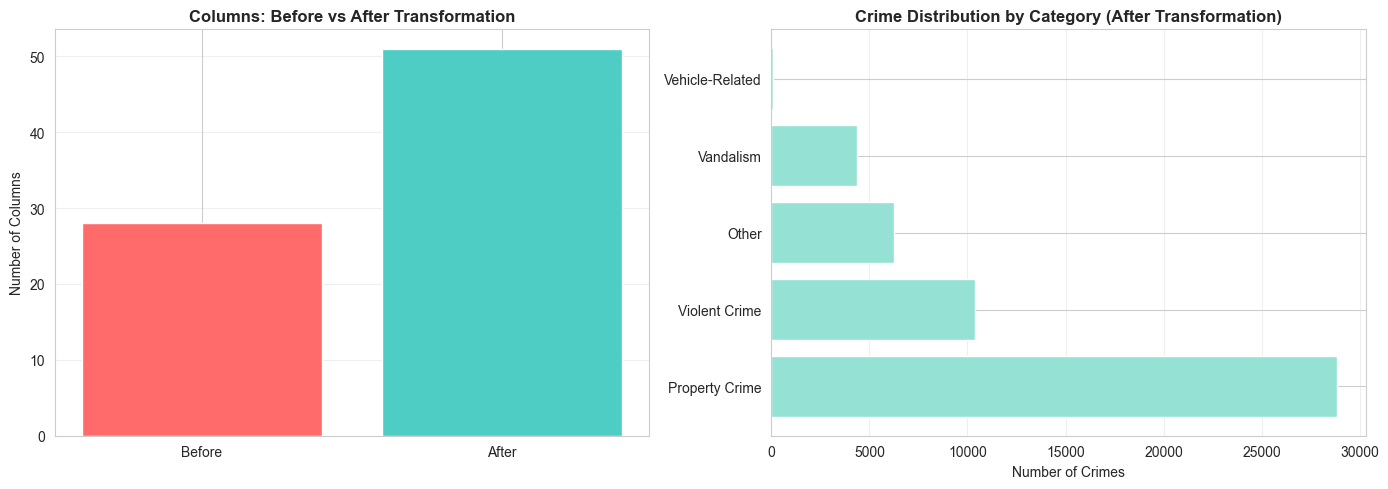


✓ Comparison completed


In [25]:
# Before and After Comparison
print("\n" + "=" * 80)
print("BEFORE vs AFTER TRANSFORMATION")
print("=" * 80)

comparison_df = pd.DataFrame({
    'Metric': ['Total Rows', 'Total Columns', 'Data Types', 'Missing Values'],
    'Before': [
        f"{len(df_test):,}",
        len(df_test.columns),
        f"{len(df_test.dtypes.unique())} types",
        f"{df_test.isnull().sum().sum():,}"
    ],
    'After': [
        f"{len(df_final_transformed):,}",
        len(df_final_transformed.columns),
        f"{len(df_final_transformed.dtypes.unique())} types",
        f"{df_final_transformed.isnull().sum().sum():,}"
    ]
})

print(comparison_df.to_string(index=False))

# Visualize transformation impact
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Column count comparison
axes[0].bar(['Before', 'After'], [len(df_test.columns), len(df_final_transformed.columns)], 
           color=['#FF6B6B', '#4ECDC4'])
axes[0].set_ylabel('Number of Columns')
axes[0].set_title('Columns: Before vs After Transformation', fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Crime category distribution
crime_cat_counts = df_final_transformed['crime_category'].value_counts()
axes[1].barh(crime_cat_counts.index, crime_cat_counts.values, color='#95E1D3')
axes[1].set_xlabel('Number of Crimes')
axes[1].set_title('Crime Distribution by Category (After Transformation)', fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Comparison completed")

In [26]:
# Export transformed data
output_filename = 'Crime_Data_Transformed.csv'
df_final_transformed.to_csv(output_filename, index=False)

print("\n" + "=" * 80)
print("EXPORT COMPLETE")
print("=" * 80)
print(f"✓ Transformed data saved to: '{output_filename}'")
print(f"   • Records: {len(df_final_transformed):,}")
print(f"   • Columns: {len(df_final_transformed.columns)}")
print(f"   • File ready for analysis and visualization!")

# Also save pivot tables
transformer.pivot_area_time.to_csv('Crime_Pivot_Area_Time.csv')
transformer.pivot_category_year.to_csv('Crime_Pivot_Category_Year.csv')
print(f"\n✓ Pivot tables also saved:")
print(f"   • Crime_Pivot_Area_Time.csv")
print(f"   • Crime_Pivot_Category_Year.csv")


EXPORT COMPLETE
✓ Transformed data saved to: 'Crime_Data_Transformed.csv'
   • Records: 50,000
   • Columns: 51
   • File ready for analysis and visualization!

✓ Pivot tables also saved:
   • Crime_Pivot_Area_Time.csv
   • Crime_Pivot_Category_Year.csv


---

## 🎯 Key Accomplishments in Data Transformation

### 1. **New Feature Creation** ✅
   - **Temporal Features:** Year, month, day, quarter, hour, time period, weekend indicator, reporting delay
   - **Crime Categories:** Severity levels, crime types, weapon involvement
   - **Demographics:** Age groups, location types, area risk scores
   - **Techniques Used:** `apply()`, `map()`, `transform()`

### 2. **Filtering and Selection** ✅
   - **Boolean Indexing:** Complex multi-condition filters
   - **loc[]:** Label-based indexing for specific rows/columns
   - **iloc[]:** Position-based indexing for sampling
   - **query():** SQL-like filtering syntax
   
### 3. **Merging and Concatenation** ✅
   - **Inner Merge:** Combined crime data with area demographics
   - **Left Merge:** Added resolution statistics
   - **Vertical Concatenation:** Combined data from different years
   - **Horizontal Concatenation:** Added area-level statistics
   
### 4. **Pivoting and Reshaping** ✅
   - **pivot_table():** Created cross-tabulations (area × time, category × year)
   - **melt():** Converted wide format to long format
   - **stack()/unstack():** Multi-level index manipulation
   - **Visual Analysis:** Heatmaps of pivoted data

### 5. **Automated Pipeline** ✅
   - **CrimeDataTransformer Class:** Complete reusable transformation pipeline
   - **Modular Design:** Each transformation step is a separate method
   - **Flexibility:** Can be customized with filters and supplementary data
   - **Reproducibility:** Same transformations can be applied to new data

---

## 📝 Transformation Statistics

| Transformation Type | Count | Examples |
|-------------------|-------|----------|
| **New Features** | 20+ | time_period, crime_category, victim_age_group, area_risk_score |
| **Boolean Filters** | 5+ | Violent crimes in 2024, Weekend weapon crimes, High-risk areas |
| **Merge Operations** | 3 | Demographics, Resolution stats, Seasonal patterns |
| **Pivot Tables** | 3 | Area×Time, Category×Year, Multi-level aggregations |
| **Reshaping Ops** | 4 | Melt, Stack, Unstack, Multiple indices |

---

## 🚀 Next Steps

The transformed dataset is now ready for:
1. **Exploratory Data Analysis (EDA)** - Discover patterns and insights
2. **Advanced Visualizations** - Create dashboards and interactive plots
3. **Statistical Analysis** - Hypothesis testing, correlation analysis
4. **Machine Learning** - Predictive modeling, clustering, classification
5. **Time Series Analysis** - Trend analysis, forecasting

---

## 💡 Most Interesting Parts for Presentation

1. **Automated Pipeline** - Showcase the CrimeDataTransformer class
2. **Crime Categorization** - Demonstrate intelligent crime grouping
3. **Time Period Analysis** - Show crime patterns by time of day
4. **Area Risk Scoring** - Highlight high-risk areas with merged demographics
5. **Interactive Pivots** - Display dynamic cross-tabulations
6. **Before/After Comparison** - Visual impact of transformations